# Topic Modelling
Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. This tutorial attempts to tackle both of these problems.

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

# Prerequisites – Download nltk stopwords and spacy model

We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

In [1]:
import sys; sys.version
import nltk; nltk.download('stopwords')
import spacy
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Packages

The core packages used in this tutorial are re, gensim, spacy and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization. Let’s import them.

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# What does LDA do?

## LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:

    1.The quality of text processing.
    2.The variety of topics the text talks about.
    3.The choice of topic modeling algorithm.
    4.The number of topics fed to the algorithm.
    5.The algorithms tuning parameters.

# Prepare Stopwords

We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [3]:
import pickle
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Import Medical Chart Data

load the  medical data in excel file via pandas

In [4]:
import os; os.getcwd()   ## get working directory

'C:\\Users\\shiji\\Desktop\\collaboration\\hero'

In [5]:
# Import Dataset
# df = pd.read_json('my_chart_cardiology.json') # load json data
df = pd.read_excel('HERO 0902 most important issue.xlsx', index_col=False) 
df.head()

,Obs,MEMBERID,consent_dt,submit_dt_hde,id,age,age_cat2,FEMALE,RACE,DIVISION,HCENV2,HCROLE2,HDEISSUE
0,1,1000672768,2020-04-14,2020-04-19,1,51,3 = 50-64,1 = Yes,1 = White,6 = Division 6 East South Central,8 = Hospital,91 = Nurse (RN/LPN) [D],Consistent readily available PPE such a clean ...
1,2,1000672768,2020-04-14,2020-04-29,2,51,3 = 50-64,1 = Yes,1 = White,6 = Division 6 East South Central,8 = Hospital,91 = Nurse (RN/LPN) [D],We could be asymptomatic carriers and be passi...
2,3,1000672768,2020-04-14,2020-07-07,3,51,3 = 50-64,1 = Yes,1 = White,6 = Division 6 East South Central,8 = Hospital,91 = Nurse (RN/LPN) [D],Asymptomatic transmissiom
3,4,1000672768,2020-04-14,2020-09-01,5,51,3 = 50-64,1 = Yes,1 = White,6 = Division 6 East South Central,8 = Hospital,91 = Nurse (RN/LPN) [D],Ever changing rules and policies are frustrati...
4,5,1000855040,2020-05-01,2020-05-01,1,44,1 = 30-49,1 = Yes,1 = White,5 = Division 5 South Atlantic,8 = Hospital,2 = Physician,burnout rates; how best to deploy staff to min...


In [6]:
df.columns  ## column names

Index(['Obs', 'MEMBERID', 'consent_dt', 'submit_dt_hde', 'id', 'age',
       'age_cat2', 'FEMALE', 'RACE', 'DIVISION', 'HCENV2', 'HCROLE2',
       'HDEISSUE'],
      dtype='object')

In [7]:
df.HDEISSUE

0       Consistent readily available PPE such a clean ...
1       We could be asymptomatic carriers and be passi...
2                               Asymptomatic transmissiom
3       Ever changing rules and policies are frustrati...
4       burnout rates; how best to deploy staff to min...
                              ...                        
7713    The new normal and finding a way to cope long ...
7714    Patients are tired of covid as an excuse for c...
7715    Consistent PPE, precautions and guidelines for...
7716    That stress takes a toll on a worker. Performa...
7717                                                  NaN
Name: HDEISSUE, Length: 7718, dtype: object

In [8]:
df.shape, df.MEMBERID.nunique()

((7718, 13), 3826)

In [9]:
## duplicate removal
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(7718, 13)

In [17]:
df.HDEISSUE.tolist()

['Consistent readily available PPE such a clean masks and gowns between patients',
 'We could be asymptomatic carriers and be passing this on to our family, etc',
 'Asymptomatic transmissiom',
 'Ever changing rules and policies are frustrating to those actually working with patients. Too many people in ivory towers making decisions that affect us. Some good some not so good. They need staff n',
 'burnout rates; how best to deploy staff to minimize burnout and optimize patient outcomes; rates of seroconversion related to time in contact with COVID-19 patients while in full PPE and less than ful',
 'How the return to normal hospital operations will go',
 'PPE , mental health and communication',
 'immunity, recurring infection',
 'Immunity',
 'Resurgence',
 'exposure risks, supply/demand of PPE, mental health impact, burnout',
 'mental health effects',
 'mental health impact; access to care for patients',
 'medical errors; cognitive bias, mental health',
 'cognitive bias, mental health',


# pre-processing the data

In [11]:
### data pre-processing class
class DataPreprocessor(object):

    def __init__(self):
        ## contraction pairs
        self.contraction_pairs=[(r'won\'t', 'will not'), (r'can\'t', 'cannot'),
                                 (r'i\'m', 'i am'), (r'ain\'t', 'is not'), 
                                 (r'(\w+)\'ll', '\g<1> will'), 
                                 (r'(\w+)n\'t', '\g<1> not'),
                                 (r'(\w+)\'ve', '\g<1> have'),
                                 (r'(\w+)\'s', '\g<1> is'),
                                 (r'(\w+)\'re', '\g<1> are'), 
                                 (r'(\w+)\'d', '\g<1> would'), 
                                 (r'&', 'and'), 
                                 (r'dammit', 'damn it'), (r'dont', 'do not'),
                                 (r'wont', 'will not') ]
        self.contraction_patterns = [(re.compile(regex), repl)\
                                     for (regex, repl) in self.contraction_pairs]
    
    @classmethod
    def split_emails(self, text):
        """
        split a text into different emails
        
        :params[in]: text, string, a piece of text made up of emails shooting 
                     back and forth
        
        :params[out]: latest email of a list of separate emails
        """
        ## pattern of reply emails
        email_reply = re.compile('----- Message -----')              
        # current utterance after removing conversation logs
        curr_utter = email_reply.split(text)[0]    
        return curr_utter
        
    def replace_contraction(self, text):
        """
        :params[in]: text, a piece of text to replace
        
        :params[out]: text, text after replacing contractions
        """
        for (pattern, repl) in self.contraction_patterns:
            text = re.sub(pattern, repl, text)
        return text
    
    ## remove unicode
    def remove_unicode(self, text):
        """ Removes unicode strings like "\u002c" and "x96" """
        text = re.sub('\s+',r' ', text)
        text = re.sub('&apos;',r' ', text)
        text = re.sub('&amp;',r'and', text)
        text = re.sub(r'(\\u[0-9A-Fa-f]+)',r' ', text)       
        text = re.sub(r'[^\x00-\x7f]',r' ',text)
        return text
  
    def replace_url(self, text):
        """ Replaces url address with "url" """
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
        text = re.sub(r'#([^\s]+)', r'\1', text)
        return text
    
    def preprocess_remove_stopwords(self, text):
        """ simple preprocessing the documents and remove stop words 
        :params[in]: text, a text
        
        :params[out]: list of words
        """
        return [word for word in simple_preprocess(str(text)) if word \
                 not in stop_words]
    
    ## preprocess messages
    def full_preprocessor(self, text):
        """ fully preprocess a document
        :params[in]: text, a string
        
        :params[out]: words, list of words
        """
        #latest_email=self.split_emails(text)
        #text1=self.replace_contraction(latest_email)
        text2=self.remove_unicode(text)
        text3=self.replace_url(text2)
        words=self.preprocess_remove_stopwords(text3)
        return words
    
    ## a static method
    @staticmethod
    def check_keywords(sentences, words):
        """
        check sentences that contain at least one word in a list
        :params[in]: sentences, a list of sentences
        :params[in]: words, a list of keywords\
    
        :params[out]: a list of tuples of form (id, text)
        """
        ## True/False of a sentence has at least one word
        res = [any([k in s for k in words]) for s in sentences] 
        return [(i,sentences[i]) for i in range(0, len(res)) if res[i]] 

    ## a static method
    @staticmethod
    def check_keywords_in(sentences, words):
        """
        check sentences that contain at least one word in a list
        :params[in]: sentences, a list of sentences
        :params[in]: words, a list of keywords\
    
        :params[out]: a list of tuples of form (id, text)
        """
        ## True/False of a sentence has at least one word
        res = [any([k in s for k in words]) for s in sentences] 
        return res 


In [12]:
## texts
df_text = df.HDEISSUE.tolist()

## Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [13]:
def sent_to_words(sentences):
    '''
    :params[in], sentences, list of sentences
    '''
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

## split sentences into words        
data_words = list(sent_to_words(df_text))

print(data_words[:1])

[['consistent', 'readily', 'available', 'ppe', 'such', 'clean', 'masks', 'and', 'gowns', 'between', 'patients']]


## Creating Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [17]:
### NOT NECESSARY   ###########

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=10.0) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10.0)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

NameError: name 'gensim' is not defined

## Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Let’s call the functions in order.
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
#data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['consistent', 'readily', 'available', 'ppe', 'clean', 'mask', 'gown', 'patient']]


## Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)


# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [31]:
## dump data into a .p file
data_4_lda={'dataframe': df, 'tokenized_texts':data_lemmatized, 'id2word':id2word,
           'corpus': corpus}
with open('hero_LDA_sep5.p', 'wb') as jf:   ### hero_LDA_sep5.p is a file, name it as you want
    pickle.dump(data_4_lda, jf)

In [6]:
## load data with pickle
with open('hero_LDA_sep5.p', 'rb') as jf:
    data0=pickle.load(jf)

In [7]:
df, data_lemmatized, id2word,corpus=data0['dataframe'],data0['tokenized_texts'],data0['id2word'],data0['corpus']

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [8]:
id2word[0]

'available'

## Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

### View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

## How to interpret this?

For example: Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

### Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [17]:
from gensim.models import LdaModel

In [18]:
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=10)
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.165836706063271

Coherence Score:  0.3235030085862554


In [22]:
help(lda_model.print_topics)

Help on method print_topics in module gensim.models.basemodel:

print_topics(num_topics=20, num_words=10) method of gensim.models.ldamodel.LdaModel instance
    Get the most significant topics (alias for `show_topics()` method).
    
    Parameters
    ----------
    num_topics : int, optional
        The number of topics to be selected, if -1 - all topics will be in result (ordered by significance).
    num_words : int, optional
        The number of words to be included per topics (ordered by significance).
    
    Returns
    -------
    list of (int, list of (str, float))
        Sequence with (topic_id, [(word, value), ... ]).



In [21]:
lda_model.print_topics()

[(0,
  '0.076*"exposure" + 0.050*"risk" + 0.030*"work" + 0.030*"patient" + 0.027*"need" + 0.024*"staff" + 0.023*"covid" + 0.018*"ppe" + 0.017*"change" + 0.016*"care"'),
 (1,
  '0.050*"risk" + 0.028*"transmission" + 0.025*"availability" + 0.024*"infection" + 0.022*"protective" + 0.021*"prevention" + 0.019*"rate" + 0.017*"testing" + 0.014*"ppe" + 0.013*"worker"'),
 (2,
  '0.078*"health" + 0.067*"mental" + 0.055*"mask" + 0.036*"public" + 0.034*"wear" + 0.026*"social" + 0.021*"importance" + 0.020*"distancing" + 0.019*"safety" + 0.016*"need"'),
 (3,
  '0.055*"testing" + 0.046*"antibody" + 0.040*"immunity" + 0.037*"covid" + 0.029*"infection" + 0.025*"long" + 0.022*"test" + 0.021*"ppe" + 0.019*"use" + 0.018*"term"'),
 (4,
  '0.052*"ppe" + 0.050*"worker" + 0.034*"healthcare" + 0.032*"treatment" + 0.032*"proper" + 0.024*"test" + 0.020*"patient" + 0.019*"testing" + 0.018*"well" + 0.016*"effective"'),
 (5,
  '0.098*"transmission" + 0.074*"immunity" + 0.046*"virus" + 0.038*"asymptomatic" + 0.022*"

## Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

 So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

## Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [19]:
import os;os.getcwd()
import time
time.time()
import os
#os.environ.update({'MALLET_HOME': r'C:/new_mallet/mallet-2.0.8/bin'})
os.environ.update({'MALLET_HOME': r'C:/mallet/bin',
                   'JAVA_HOME': r'C:/Program Files/Java/jdk-14.0.2/bin'})

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# the number of iterations may affect the coherence score
# hyper-parameter optimization -- can improve the performance
# mallet_path = 'C:\\new_mallet\\mallet-2.0.8\\bin\\mallet.bat'
mallet_path = 'C:\\mallet\\bin\\mallet'
start_time = time.time()
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, 
                                             id2word=id2word,iterations=8000)
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, 
                                           dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
time_cost = time.time()-start_time

CalledProcessError: Command 'C:\mallet\bin\mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\shiji\AppData\Local\Temp\f56d57_corpus.txt --output C:\Users\shiji\AppData\Local\Temp\f56d57_corpus.mallet' returned non-zero exit status 1.

In [69]:
## iterations = 3000, without optimizing hyper-parameters, coherence val. = 0.537
## iterations = 5000, without optimizing hyper-parameters, coherence val. = 0.577
## iterations = 8000, without optimizing hyper-parameters, coherence val. = 0.573


In [68]:
time_cost

4223.827516317368

In [70]:
## save model in a .p file: lda model, dataframe, corpus, and id2word mapping
pickle.dump((ldamallet,df,data_lemmatized, corpus, id2word), open( "myChartAug18.p", "wb" ))

## Clustering based on topics
### vectorize documents by topics

In [120]:

## get path to document topic text file
optimal_model.fdoctopics()
## load document topics, i.e., the weights of each topic in every document
doc_topics=optimal_model.load_document_topics()

In [121]:
doc_topic_mat=list(doc_topics)

10

In [94]:
## document topic weights matrix
doc_topic_wt = [[w for i,w in it] for it in doc_topic_mat]

In [95]:
## np.array
doc_topic_np = np.array(doc_topic_wt)

In [96]:
## take logarithm
log_doc_topic = np.log(doc_topic_np)

In [97]:
log_doc_topic.shape

(167042, 10)

In [98]:
from sklearn.cluster import MiniBatchKMeans

In [99]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, batch_size=200000, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    ## return the sse and cluster numbers
    return list(iters),sse


In [8]:
nums,sse=find_optimal_clusters(log_doc_topic, 100)

NameError: name 'find_optimal_clusters' is not defined

In [101]:
nums[12]

26

In [102]:
# Use k-means method
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25)
kmeans.fit(log_doc_topic)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=25, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [131]:
model_data={'model':kmeans, 'doc_topics':log_doc_topic}
with open('kmeans_model_dec27.p', 'wb') as fi:
    pickle.dump(model_data, fi)

In [7]:
kmeans.cluster_centers_

NameError: name 'kmeans' is not defined

In [104]:
## cluster labels
kmeans.labels_.shape

(167042,)

In [105]:
df['cluster_label'] = kmeans.labels_

In [110]:
import random

In [106]:
## save the data to pickle
pickle.dump((df,sse, nums), open("myChartClusterDec28.p", "wb"))

In [106]:
## keep patients' emails
cluster_df0 = cluster_df[cluster_df.MESSAGE_TO_FROM_PATIENT=='From Patient']

In [21]:
cluster_df0.groupby('cluster_label').count()

NameError: name 'cluster_df0' is not defined

In [114]:
cluster_labels, sample_texts, clean_messages=[],[],[]
## random select 
for lab in range(20):
    ls0 = cluster_df0[cluster_df0.cluster_label==lab].MESSAGE_TEXT.to_list()
    ls1 = cluster_df0[cluster_df0.cluster_label==lab].Clean_message.to_list()
    if len(ls0)<=200:
        cluster_labels.extend([lab]*len(ls0))
        sample_texts.extend(ls0)
        clean_messages.extend(ls1)
    else: # greater than 200, draw random sample
        ind0 = random.sample(list(range(len(ls0))), 200)
        cluster_labels.extend([lab]*200)
        sample_texts.extend([ls0[i] for i in ind0])
        clean_messages.extend([ls1[i] for i in ind0])

In [119]:
tmp_dict = {'cluster':cluster_labels, 'sample_text':sample_texts, 'clean_message':clean_messages}

In [122]:
tmp_df=pd.DataFrame.from_dict(tmp_dict)
tmp_df.to_excel('sample_text.xlsx', index=False)

In [111]:
random.sample(list(range(100)), 10)

[99, 42, 45, 29, 9, 53, 47, 18, 17, 74]

In [89]:
df0 = df[df.cluster_label==0]

In [92]:
df0.shape[0]

27316

In [107]:
## number of elements in each cluster
num_cluster = []
for it in range(25):
    num_cluster.append(df[df.cluster_label==it].shape[0])

In [22]:
num_cluster

NameError: name 'num_cluster' is not defined

In [110]:
df.to_excel('myChartMessage_clusters_dec28.xlsx', index=False)

In [ ]:
import pickle
pickle.s

In [99]:
import random

In [106]:
l0 = [1, 4, 6, 8, 10]
random.sample(l0, 3)

[8, 4, 10]

In [107]:
l0=[]
l0.extend([0]*4)

In [109]:
l0.extend([1]*4)

In [110]:
l0

[0, 0, 0, 0, 1, 1, 1, 1]

In [111]:
cluster_labels, sample_texts=[],[]
## random select 
for lab in range(20):
    ls0 = df[df.cluster_label==lab].MESSAGE_TEXT.to_list()
    cluster_labels.extend([lab]*100)
    sample_texts.extend(random.sample(ls0, 100))

In [114]:
tmp_dict = {'cluster_label':cluster_labels, 'sample_text':sample_texts}

In [116]:
tmp_df=pd.DataFrame.from_dict(tmp_dict)
tmp_df.to_excel('sample_text.xlsx', index=False)

In [109]:
## import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

What we can do is reduce the number of dimensions drastically whilst trying to retain as much of the ‘variation’ in the information as possible. This is where we get to dimensionality reduction. Lets first take a look at something known as Principal Component Analysis.

PCA is a technique for reducing the number of dimensions in a dataset whilst retaining most information. It is using the correlation between some dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed. It does not do this using guesswork but using hard mathematics and it uses something known as the eigenvalues and eigenvectors of the data-matrix. These eigenvectors of the covariance matrix have the property that they point along the major directions of variation in the data. These are the directions of maximum variation in a dataset.

T-Distributed Stochastic Neighbouring Entities (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one. The original paper describes the working of t-SNE as:

“t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.

In [116]:
import time
## use t-SNE method to reduce dimension and to visualize data
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=200.0)
tsne_results = tsne.fit_transform(log_doc_topic)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 345270 samples in 2.809s...
[t-SNE] Computed neighbors for 345270 samples in 67.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 345270
[t-SNE] Computed conditional probabilities for sample 2000 / 345270
[t-SNE] Computed conditional probabilities for sample 3000 / 345270
[t-SNE] Computed conditional probabilities for sample 4000 / 345270
[t-SNE] Computed conditional probabilities for sample 5000 / 345270
[t-SNE] Computed conditional probabilities for sample 6000 / 345270
[t-SNE] Computed conditional probabilities for sample 7000 / 345270
[t-SNE] Computed conditional probabilities for sample 8000 / 345270
[t-SNE] Computed conditional probabilities for sample 9000 / 345270
[t-SNE] Computed conditional probabilities for sample 10000 / 345270
[t-SNE] Computed conditional probabilities for sample 11000 / 345270
[t-SNE] Computed conditional probabilities for sample 12000 / 345270
[t-SNE] Computed conditional probab

In [114]:
## import seaborn
import seaborn as sns

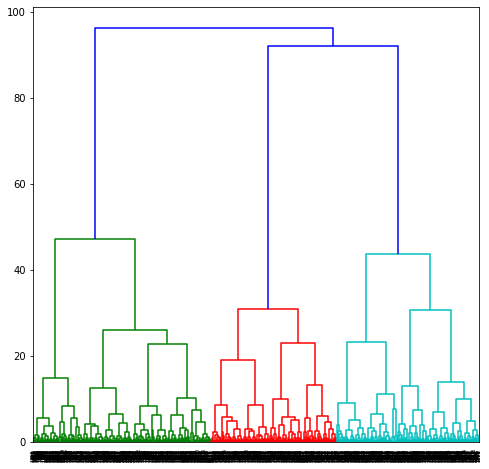

In [124]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
#Z = sch.linkage(ytdist, 'single')
dendrogram = sch.dendrogram(sch.linkage(tsne_results[0:2000,:], method='ward'), ax=axes)

In [125]:
fig.savefig('dendrogram2000.png', quality=95, bbox_inches='tight')

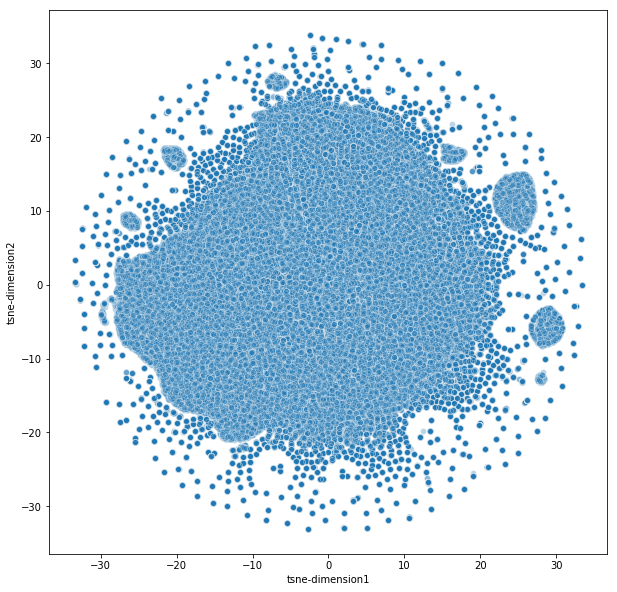

In [117]:
df_subset=pd.DataFrame()
df_subset['tsne-dimension1'] = tsne_results[:,0]
df_subset['tsne-dimension2'] = tsne_results[:,1]

plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-dimension1", y="tsne-dimension2",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [ ]:
fig.savefig('quad_kernel.png', quality=95, bbox_inches='tight')

In [109]:
xt = np.random.normal(size=(100,))*100
xt1 = sch.linkage(xt, 'single')
plt.figure()
dn = sch.dendrogram(xt1)

ValueError: Length n of condensed distance matrix 'y' must be a binomial coefficient, i.e.there must be a k such that (k \choose 2)=n)!

In [89]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(tsne_results, method='ward'))

MemoryError: 

# show topics

In [1]:
pprint(ldamallet.show_topics(formatted=True))

Pretty printing has been turned OFF


In [2]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

NameError: name 'pprint' is not defined

Just by changing the LDA algorithm and number of topics, the coherence score from .39 to .60. Not bad!

## How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
start_time = time.time()
# Can take a long time to run.
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=6, limit=21, step=2)
time_cost = time.time()-start_time

CalledProcessError: Command 'mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\shiji\AppData\Local\Temp\100cae_corpus.txt --output C:\Users\shiji\AppData\Local\Temp\100cae_corpus.mallet' returned non-zero exit status 1.

In [74]:
time_cost

2966.1473474502563

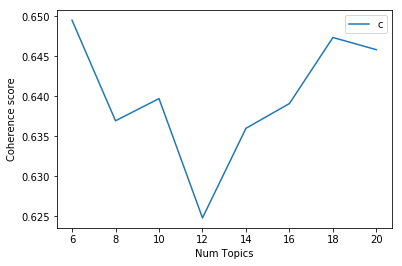

In [75]:
# Show graph
start=6; limit=21; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [76]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 6  has Coherence Value of 0.6495
Num Topics = 8  has Coherence Value of 0.637
Num Topics = 10  has Coherence Value of 0.6397
Num Topics = 12  has Coherence Value of 0.6248
Num Topics = 14  has Coherence Value of 0.636
Num Topics = 16  has Coherence Value of 0.6391
Num Topics = 18  has Coherence Value of 0.6474
Num Topics = 20  has Coherence Value of 0.6458


In [77]:
optimal_model=model_list[2]

In [119]:
optimal_model.save('dec28_lda_model')

In [133]:
## use lda model for prediction
optimal_model.__getitem__([(1,1),(2,1),(5,1),(10,2)])

[(0, 0.1414141414141414),
 (1, 0.09090909090909091),
 (2, 0.09292929292929293),
 (3, 0.09090909090909091),
 (4, 0.1292929292929293),
 (5, 0.09090909090909091),
 (6, 0.09090909090909091),
 (7, 0.09090909090909091),
 (8, 0.09090909090909091),
 (9, 0.09090909090909091)]

In [6]:
optimal_model.print_topics(num_topics=-1, num_words=20)

NameError: name 'optimal_model' is not defined

In [112]:
optimal_model.fwordweights()

'/tmp/c6fbe9_wordweights.txt'

In [113]:
f1 = open('/tmp/c6fbe9_wordweights.txt', 'r')
lines = f1.readlines()

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/c6fbe9_wordweights.txt'

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [69]:
model_list

In [12]:
import pickle

In [ ]:
## save model in a .p file: lda model, dataframe, corpus, and id2word mapping
pickle.dump((x, model_list, df,data_lemmatized, corpus, id2word), open( "myChartAug8.p", "wb" ))

In [13]:
## pickle load .p file
(x, model_list, df,data_lemmatized, corpus, id2word) = pickle.load( open( "myChartAug8.p", "rb" ) )

FileNotFoundError: [Errno 2] No such file or directory: 'myChartAug8.p'

In [14]:
df.shape

(345270, 19)

In [54]:
id2word1

In [5]:
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=20))
# Those were the topics for the chosen LDA model.

NameError: name 'optimal_model' is not defined

In [4]:
pprint(optimal_model.print_topics(-1, 30))

Pretty printing has been turned ON


In [79]:
optimal_topics=optimal_model.print_topics(-1, 30)

In [80]:
df_optimal_topics=pd.DataFrame(optimal_topics)

In [81]:
df_optimal_topics.columns=['Topic_id', 'Keywords']

In [3]:
df_optimal_topics

NameError: name 'df_optimal_topics' is not defined

## Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [87]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [23]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.Clean_Message.to_list())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

NameError: name 'format_topics_sentences' is not defined

## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [24]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# show
sent_topics_sorteddf_mallet.head()

NameError: name 'pd' is not defined

In [90]:
## topics and their typical examples
with pd.ExcelWriter('topic_typical_examples.xlsx') as writer: 
    df_optimal_topics.to_excel(writer, sheet_name='topics', index=False)
    sent_topics_sorteddf_mallet.to_excel(writer, sheet_name='typical examples', index=False)
writer.close()

In [25]:
sent_topics_sorteddf_mallet.rename(columns={'Topic_Num':'Topic_id'})

NameError: name 'sent_topics_sorteddf_mallet' is not defined

In [26]:
df_sent=sent_topics_sorteddf_mallet
df_sent[df_sent.Topic_Num==0.0].Text.to_list()

NameError: name 'sent_topics_sorteddf_mallet' is not defined

In [27]:
## print 5 examples for each topic
for i in range(6):
    for rep in range(0,5):
        print('Topic '+str(i)+'  Example '+str(rep)+' ---->  ' +df_sent.Text.to_list()[(5*i+rep)])
        print('')

NameError: name 'df_sent' is not defined

The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [28]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

NameError: name 'df_topic_sents_keywords' is not defined

In [335]:
len(data)

75138

In [29]:
I = 0
print(df_dominant_topics.loc[i, 'Topic_Keywords'])
print(df.loc[i, 'MESSAGE_TEXT'])

NameError: name 'df_dominant_topics' is not defined

In [297]:
df.columns

Index(['DEPARTMENT_NAME', 'ENCOUNTER_DATE', 'ENCOUNTER_ID', 'ENCOUNTER_TYPE',
       'FINANCIAL_CLASS', 'MESSAGE_DATE', 'MESSAGE_ID', 'MESSAGE_TEXT',
       'MESSAGE_TO_FROM_PATIENT', 'MESSAGE_TO_FROM_PROVIDER', 'MESSAGE_TYPE',
       'MRN', 'PAT_ID', 'PAT_NAME', 'PROVIDER_TYPE'],
      dtype='object')

In [336]:
aug_df = df.merge(df_dominant_topic, left_on='MESSAGE_TEXT', right_on='Text')

In [337]:
aug_df.columns

Index(['DEPARTMENT_NAME', 'ENCOUNTER_DATE', 'ENCOUNTER_ID', 'ENCOUNTER_TYPE',
       'FINANCIAL_CLASS', 'MESSAGE_DATE', 'MESSAGE_ID', 'MESSAGE_TEXT',
       'MESSAGE_TO_FROM_PATIENT', 'MESSAGE_TO_FROM_PROVIDER', 'MESSAGE_TYPE',
       'MRN', 'PAT_ID', 'PAT_NAME', 'PROVIDER_TYPE', 'Document_No',
       'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text'],
      dtype='object')

In [338]:
print('df shape:', df.shape)
print('df_topics shape:', df_dominant_topic.shape)
print('augmented shape:',aug_df.shape)

df shape: (75138, 15)
df_topics shape: (75138, 5)
augmented shape: (75460, 20)


In [339]:
## group by 'dominant_topic' then count MRN
count_summary = aug_df[['MRN', 'Dominant_Topic']].groupby(['Dominant_Topic']).agg(['count','nunique'])

In [340]:
count_summary.columns=['Number_of_Texts', 'Number_of_MRNs']

In [341]:
count_summary

,Number_of_Texts,Number_of_MRNs
Dominant_Topic,,
0.0,11923,2638
1.0,6376,2300
2.0,5278,2155
3.0,10362,2884
4.0,5721,1861
5.0,5411,1086
6.0,5922,1440
7.0,6612,1642
8.0,9502,2092


In [65]:
list_topic=topic_counts.index.astype(int).to_list()

In [66]:
list_num = topic_counts.to_list() # list of number of documents dominated by topics


In [67]:
perc = list(np.array(list_num)/np.sum(list_num))

In [71]:
## count summary statistics
sum_dict = {'Topics':list_topic, 'Documents': list_num, 'Percents':perc}
count_sum = pd.DataFrame(sum_dict)

In [69]:
print(count_sum.to_string(index=False))

 #Documents  Percents  Topics
     111356  0.322519       0
      92631  0.268286       3
      62438  0.180838       4
      50953  0.147574       5
      16636  0.048183       2
      11256  0.032601       1


In [79]:
count_sum.set_index('Topics')

,Documents,Percents
Topics,,
0,111356,0.322519
3,92631,0.268286
4,62438,0.180838
5,50953,0.147574
2,16636,0.048183
1,11256,0.032601
